# Cafe sales database setup
This notebook simulates the duty of data engineer on setting up a new database for a cafe with the past sale records in `dirty_cafe_sales.csv`.\
It will be further separated into 3 main section.
1. Data Exploration
2. Creating database with star schema
3. Simple exploratory analysis on aggregated data

## Section 1 : Data Exploration

Start by importing data transformation tools, we will focused on `pyspark` here

In [12]:
from pyspark.sql import (SparkSession, types as t, functions as F, Window,)

spark = (SparkSession.builder.appName('etl_with_pyspark')
		# .config("spark.jars", "/home/setta/drivers/postgresql-42.7.8.jar") 
		.getOrCreate()
		)

Import Dataset

In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ahmedmohamed2003/cafe-sales-dirty-data-for-cleaning-training")

df = spark.read.csv(path+'/dirty_cafe_sales.csv',header=True)

See first 20 rows of DataFrame.

In [14]:
df.show()

+--------------+--------+--------+--------------+-----------+--------------+--------+----------------+
|Transaction ID|    Item|Quantity|Price Per Unit|Total Spent|Payment Method|Location|Transaction Date|
+--------------+--------+--------+--------------+-----------+--------------+--------+----------------+
|   TXN_1961373|  Coffee|       2|           2.0|        4.0|   Credit Card|Takeaway|      2023-09-08|
|   TXN_4977031|    Cake|       4|           3.0|       12.0|          Cash|In-store|      2023-05-16|
|   TXN_4271903|  Cookie|       4|           1.0|      ERROR|   Credit Card|In-store|      2023-07-19|
|   TXN_7034554|   Salad|       2|           5.0|       10.0|       UNKNOWN| UNKNOWN|      2023-04-27|
|   TXN_3160411|  Coffee|       2|           2.0|        4.0|Digital Wallet|In-store|      2023-06-11|
|   TXN_2602893|Smoothie|       5|           4.0|       20.0|   Credit Card|    NULL|      2023-03-31|
|   TXN_4433211| UNKNOWN|       3|           3.0|        9.0|         ERR

See columns' name and their data type with `pyspark.sql.DataFrame.dtypes`

In [15]:
df.dtypes

[('Transaction ID', 'string'),
 ('Item', 'string'),
 ('Quantity', 'string'),
 ('Price Per Unit', 'string'),
 ('Total Spent', 'string'),
 ('Payment Method', 'string'),
 ('Location', 'string'),
 ('Transaction Date', 'string')]

From `df.show()` and `df.dtypes`, we can see that all columns are string type with some unwanted value including  `'ERROR' 'UNKNOWN' 'None'`. \
So, we need to replace `'ERROR' 'UNKNOWN' 'None'` with actual `None`.

In [16]:
df = df.replace(['ERROR', 'UNKNOWN','None'], [None,None,None])

Before further operation, let's change columns' name and convert to appropiate type

In [17]:
df = df.toDF('transaction_id',
               	'item_name',
         		'item_quantity',
     			'item_ppu',
				'item_total_price',
				'payment_type',
				'location_type',
				'transaction_date'
			   )

df = df.withColumn("item_quantity", F.col("item_quantity").cast("integer")) \
       	.withColumn("item_ppu", F.col("item_ppu").cast("double")) \
       	.withColumn("item_total_price", F.col("item_total_price").cast("double"))\
		.withColumn("transaction_date", F.col("transaction_date").cast("date"))

df.dtypes

[('transaction_id', 'string'),
 ('item_name', 'string'),
 ('item_quantity', 'int'),
 ('item_ppu', 'double'),
 ('item_total_price', 'double'),
 ('payment_type', 'string'),
 ('location_type', 'string'),
 ('transaction_date', 'date')]

## Section 2 : Creating database with the Star Schema

Following the Star Schema, We will normalize the data to:
* Fact table
	* `fact_order` 
		* `transaction_id`(PK)
		* `item_id`(FK)
		* `item_quantity`
		* `item_total_price`
		* `payment_type_id`(FK)
		* `location_type_id`(FK)
		* `transaction_date`
							
* Dimension tables
	* `dim_item`
		* `item_id`(PK)
		* `item_name`
		* `item_ppu` (price per unit)
	* `dim_payment`
		* `payment_type_id`(PK)
		* `payment_type`
	* `dim_location`
		* `location_type_id`(PK)
		* `location_type`
<div align="center">
	<!-- <img src="erd.png" width="937" height="582"> -->
	<img src="erd.png" width="600" height="375">
</div>


After designing ERD diagram, let's create the tables (this example use the generated SQL script from ERD tool in pgAdmin 4.)

In [ ]:
import psycopg2

# create postgreSQL connection
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    database="airflow",
    user="postgres",
    password="postgres"
)
# create cursor for execute SQL in postgreSQL connection
cur = conn.cursor()

# see detail in 0_database_design.sql
with open("1_database_setup.sql", "r") as f:
    sql_script = f.read()

cur.execute(sql_script)

# close cursor and connection
cur.close()
conn.close()

First, we need to see all unique values in `'Item' 'Payment Method' 'Location'` columns, this can be done with `pyspark.sql.DataFrame.groupingSets`.\
(Assign the result to `dim_df` for further use in creating dimension tables.)

In [19]:
dim_df = (df.dropna().groupingSets(
	[["item_name","item_ppu"], ["payment_type"],["location_type"]],
  	'item_name','item_ppu','payment_type','location_type'
  	)
  	.count()
  	.orderBy("item_name", "payment_type",'location_type')
)

dim_df.show()

+---------+--------+--------------+-------------+-----+
|item_name|item_ppu|  payment_type|location_type|count|
+---------+--------+--------------+-------------+-----+
|     NULL|    NULL|          NULL|     In-store| 1542|
|     NULL|    NULL|          NULL|     Takeaway| 1547|
|     NULL|    NULL|          Cash|         NULL| 1018|
|     NULL|    NULL|   Credit Card|         NULL| 1002|
|     NULL|    NULL|Digital Wallet|         NULL| 1069|
|     Cake|     3.0|          NULL|         NULL|  385|
|   Coffee|     2.0|          NULL|         NULL|  367|
|   Cookie|     1.0|          NULL|         NULL|  391|
|    Juice|     3.0|          NULL|         NULL|  427|
|    Salad|     5.0|          NULL|         NULL|  418|
| Sandwich|     4.0|          NULL|         NULL|  391|
| Smoothie|     4.0|          NULL|         NULL|  338|
|      Tea|     1.5|          NULL|         NULL|  372|
+---------+--------+--------------+-------------+-----+



### 2.1 Creating dimension tables 
and save to `.csv` files for further loading into Database

In [20]:
dim_item = dim_df.select('item_name','item_ppu').drop_duplicates()
w = Window.orderBy(dim_item.item_name)
dim_item = dim_item.withColumn('item_id', F.row_number().over(w)-1).select('item_id','item_name','item_ppu')

dim_item_path ='/home/setta/projects_venv/1-Cafe-Orders/dim_tables/dim_item.csv'
dim_item.toPandas().to_csv(dim_item_path, header=True,index=False)

dim_item.show()

+-------+---------+--------+
|item_id|item_name|item_ppu|
+-------+---------+--------+
|      0|     NULL|    NULL|
|      1|     Cake|     3.0|
|      2|   Coffee|     2.0|
|      3|   Cookie|     1.0|
|      4|    Juice|     3.0|
|      5|    Salad|     5.0|
|      6| Sandwich|     4.0|
|      7| Smoothie|     4.0|
|      8|      Tea|     1.5|
+-------+---------+--------+



In [21]:
dim_payment = dim_df.select('payment_type').drop_duplicates()
w = Window.orderBy(dim_payment.payment_type)
dim_payment = dim_payment.withColumn('payment_type_id', F.row_number().over(w)-1).select('payment_type_id','payment_type')

dim_payment_path ='/home/setta/projects_venv/1-Cafe-Orders/dim_tables/dim_payment.csv'
dim_payment.toPandas().to_csv(dim_payment_path, header=True,index=False)

dim_payment.show()

+---------------+--------------+
|payment_type_id|  payment_type|
+---------------+--------------+
|              0|          NULL|
|              1|          Cash|
|              2|   Credit Card|
|              3|Digital Wallet|
+---------------+--------------+



In [22]:
dim_location = dim_df.select('location_type').drop_duplicates()
w = Window.orderBy(dim_location.location_type)
dim_location = dim_location.withColumn('location_type_id', F.row_number().over(w)-1).select('location_type_id','location_type')

dim_location_path ='/home/setta/projects_venv/1-Cafe-Orders/dim_tables/dim_location.csv'
dim_location.toPandas().to_csv(dim_location_path, header=True,index=False)

dim_location.show()

+----------------+-------------+
|location_type_id|location_type|
+----------------+-------------+
|               0|         NULL|
|               1|     In-store|
|               2|     Takeaway|
+----------------+-------------+



Load into dimension tables with `psycopg2`

In [23]:
import psycopg2

# create postgreSQL connection
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    database="airflow",
    user="postgres",
    password="postgres"
)

# create cursor for execute SQL in postgreSQL connection
cur = conn.cursor()

paths = [dim_item_path,dim_payment_path,dim_location_path]
dims = ['dim_item','dim_payment','dim_location']

for path,dim in zip(paths,dims):
    with open(path, "r") as file:
        cur.copy_expert(
            f"COPY {dim} FROM STDIN WITH CSV HEADER DELIMITER AS ',' QUOTE '\"'",
            file,
        )
conn.commit()

See all dimension tables

In [24]:
for dim in dims:
  print('\n',dim)
  cur.execute(
            f"SELECT * FROM {dim} "
        )
  rows = cur.fetchall()
  for row in rows:
      print(row)


 dim_item
(0, None, None)
(1, 'Cake', Decimal('3.0'))
(2, 'Coffee', Decimal('2.0'))
(3, 'Cookie', Decimal('1.0'))
(4, 'Juice', Decimal('3.0'))
(5, 'Salad', Decimal('5.0'))
(6, 'Sandwich', Decimal('4.0'))
(7, 'Smoothie', Decimal('4.0'))
(8, 'Tea', Decimal('1.5'))

 dim_payment
(0, None)
(1, 'Cash')
(2, 'Credit Card')
(3, 'Digital Wallet')

 dim_location
(0, None)
(1, 'In-store')
(2, 'Takeaway')


### 2.2 Creating Fact tables
Let's see the remaining df

In [25]:
df.toPandas().sample(10)

,transaction_id,item_name,item_quantity,item_ppu,item_total_price,payment_type,location_type,transaction_date
482,TXN_4573576,None,2.0,3.0,6.0,Cash,In-store,2023-07-05
4767,TXN_8725721,Sandwich,1.0,4.0,4.0,Cash,None,2023-06-04
1514,TXN_8149585,Juice,1.0,3.0,3.0,Credit Card,None,2023-02-21
1016,TXN_7223120,Juice,1.0,3.0,3.0,None,None,2023-03-13
9021,TXN_9455679,Salad,5.0,5.0,25.0,None,Takeaway,2023-05-18
1586,TXN_2018236,Coffee,5.0,2.0,10.0,Cash,None,2023-04-19
8178,TXN_1982031,Cookie,4.0,1.0,4.0,Cash,Takeaway,2023-02-03
5952,TXN_9171458,Cake,2.0,3.0,6.0,None,None,2023-03-29
4854,TXN_1839407,Cookie,3.0,1.0,3.0,Cash,None,2023-03-15
727,TXN_8297135,None,2.0,4.0,NaN,None,None,2023-09-16


We can see that all columns except `transaction_id` still contains `Null/NaN`. \
Actually, we can resolve many `Null/NaN` in many columns including:
1. Resolve `item_ppu` from a known `item_name`.
2. Resolve `item_quantity` `item_ppu` `item_total_price` with the relationship `item_quantity * item_ppu = item_total_price`.
3. Finally, resolve `item_name` from a known `item_ppu` ,if a `item_ppu` is unique.

Note:
  * We have to resolve `Null/NaN` respectively to step 1 to step 3, or we have to do some steps twice.
  * payment_type, location_type, transaction_date can't be resolved.

In [26]:
# Step 1
df = df.withColumn("item_ppu", 
                   	F.when(F.col("item_ppu").isNull(),
											F.when(F.col("item_name") == 'Cookie', 1)
											.when(F.col("item_name") == 'Tea', 1.5)
											.when(F.col("item_name") == 'Coffee', 2)
											.when(F.col("item_name") == 'Juice', 3)
											.when(F.col("item_name") == 'Cake', 3)
											.when(F.col("item_name") == 'Sandwich', 4)
											.when(F.col("item_name") == 'Smoothie', 4)
           						.when(F.col("item_name") == 'Salad', 5)
            					)
										.otherwise(F.col("item_ppu"))
										)

In [27]:
# Step 2
df = df.withColumn('item_total_price',

                    F.when(F.col("item_total_price").isNull(),df.item_quantity * df.item_ppu)
										.otherwise(df.item_total_price)
            				)
df = df.withColumn('item_ppu',
                    F.when(F.col("item_ppu").isNull(),df.item_total_price / df.item_quantity)
										.otherwise(df.item_ppu)
            				)
df = df.withColumn('item_quantity',
                    F.when(F.col("item_quantity").isNull(),df.item_total_price / df.item_ppu)
										.otherwise(df.item_quantity)
            				)

In [28]:
# Step 3 : Only item_ppu in [1.0, 1.5, 2.0, 5.0] can be replaced with the actual item_name. 
df = df.withColumn("item_name", 
                   	F.when(F.col("item_name").isNull(),
											F.when(F.col("item_ppu") == 1.0, 'Cookie')
											.when(F.col("item_ppu") == 1.5, 'Tea')
											.when(F.col("item_ppu") == 2.0, 'Coffee')
											.when(F.col("item_ppu") == 5.0, 'Salad')
            					)
										.otherwise(F.col("item_name"))
										)

Here is some example scenarios that should not return a result
1. A known `item_name` with `Null` in `item_ppu`
2. A `item_ppu` in `[1.0, 1.5, 2.0, 5.0]` with `Null` in `item_name`
3. A known `item_ppu` and `item_quantity` with `Null` in `item_total_price`
4. A known `item_ppu` and `item_total_price` with `Null` in `item_quantity`
5. A known `item_quantity` and `item_total_price` with `Null` in `item_ppu`

In [29]:
case1 = df.filter(~F.col("item_name").isNull()).filter(F.col("item_ppu").isNull()).isEmpty()

case2 = df.filter(F.col("item_ppu").isin( [1.0, 1.5, 2.0, 5.0])).filter(F.col("item_name").isNull()).isEmpty()

case3 = df.filter(~F.col("item_ppu").isNull()).filter(~F.col("item_quantity").isNull()).filter(F.col("item_total_price").isNull()).isEmpty()

case4 = df.filter(~F.col("item_ppu").isNull()).filter(~F.col("item_total_price").isNull()).filter(F.col("item_quantity").isNull()).isEmpty()

case5 = df.filter(~F.col("item_quantity").isNull()).filter(~F.col("item_total_price").isNull()).filter(F.col("item_ppu").isNull()).isEmpty()

case1 & case2 & case3 & case4 & case5

True

Create a Fact Table \
Using `pyspark.sql.functions.broadcast` for more efficient join

In [30]:
# Use F.broadcast on small table in joining
df = df.join(F.broadcast(dim_item), on="item_name", how="left")
df = df.join(F.broadcast(dim_payment), on="payment_type", how="left")
df = df.join(F.broadcast(dim_location), on="location_type", how="left")
df.show()


+-------------+--------------+---------+--------------+-------------+--------+----------------+----------------+-------+--------+---------------+----------------+
|location_type|  payment_type|item_name|transaction_id|item_quantity|item_ppu|item_total_price|transaction_date|item_id|item_ppu|payment_type_id|location_type_id|
+-------------+--------------+---------+--------------+-------------+--------+----------------+----------------+-------+--------+---------------+----------------+
|     Takeaway|   Credit Card|   Coffee|   TXN_1961373|          2.0|     2.0|             4.0|      2023-09-08|      2|     2.0|              2|               2|
|     In-store|          Cash|     Cake|   TXN_4977031|          4.0|     3.0|            12.0|      2023-05-16|      1|     3.0|              1|               1|
|     In-store|   Credit Card|   Cookie|   TXN_4271903|          4.0|     1.0|             4.0|      2023-07-19|      3|     1.0|              2|               1|
|         NULL|       

In [31]:
# select neccesary columns and rearrange them
fact_order = df.select(
    "transaction_id",
    "item_id",
    "item_quantity",
    "item_total_price",
    "payment_type_id",
    "location_type_id",
    "transaction_date"
)

fact_order = fact_order.withColumn("item_quantity", F.col("item_quantity").cast("integer")) 

########################################################################################################################################
# Note: sparkDataFrame.toPandas().to_csv    -->     can't handle null as integer, it's will change the columns with Null to numeric 
#                                                   solve by 1. fillna(value), 2. change column to numeric type, 3. dropna
########################################################################################################################################
print('Total Rows : ', fact_order.count())
print('Total Rows (drop all na) : ',fact_order.dropna().count())
print('Total Rows (drop int na): ',fact_order.dropna(subset=['item_id','item_quantity','payment_type_id','location_type_id']).count())

Total Rows :  10000
Total Rows (drop all na) :  3771
Total Rows (drop int na):  3943


In [32]:
# Let's go with fillna with 0
fact_order = fact_order.fillna(0)
fact_order.show()

+--------------+-------+-------------+----------------+---------------+----------------+----------------+
|transaction_id|item_id|item_quantity|item_total_price|payment_type_id|location_type_id|transaction_date|
+--------------+-------+-------------+----------------+---------------+----------------+----------------+
|   TXN_1961373|      2|            2|             4.0|              2|               2|      2023-09-08|
|   TXN_4977031|      1|            4|            12.0|              1|               1|      2023-05-16|
|   TXN_4271903|      3|            4|             4.0|              2|               1|      2023-07-19|
|   TXN_7034554|      5|            2|            10.0|              0|               0|      2023-04-27|
|   TXN_3160411|      2|            2|             4.0|              3|               1|      2023-06-11|
|   TXN_2602893|      7|            5|            20.0|              2|               0|      2023-03-31|
|   TXN_4433211|      0|            3|        

Load the cleaned fact_order to the database

In [33]:
fact_order_path ='/home/setta/projects_venv/1-Cafe-Orders/dim_tables/fact_order.csv'
fact_order.toPandas().to_csv(fact_order_path, header=True,index=False)

with open(fact_order_path, "r") as file:
    cur.copy_expert(
        f"COPY fact_order FROM STDIN WITH CSV HEADER DELIMITER AS ',' QUOTE '\"'",
        file,
    )
	
conn.commit()

In [34]:

cur.execute(
          f"SELECT * FROM fact_order LIMIT 20 "
      )
rows = cur.fetchall()
for row in rows:
    print(row)

# close cursor and connection
cur.close()
conn.close()

('TXN_1961373', 2, 2, Decimal('4.0'), 2, 2, datetime.date(2023, 9, 8))
('TXN_4977031', 1, 4, Decimal('12.0'), 1, 1, datetime.date(2023, 5, 16))
('TXN_4271903', 3, 4, Decimal('4.0'), 2, 1, datetime.date(2023, 7, 19))
('TXN_7034554', 5, 2, Decimal('10.0'), 0, 0, datetime.date(2023, 4, 27))
('TXN_3160411', 2, 2, Decimal('4.0'), 3, 1, datetime.date(2023, 6, 11))
('TXN_2602893', 7, 5, Decimal('20.0'), 2, 0, datetime.date(2023, 3, 31))
('TXN_4433211', 0, 3, Decimal('9.0'), 0, 2, datetime.date(2023, 10, 6))
('TXN_6699534', 6, 4, Decimal('16.0'), 1, 0, datetime.date(2023, 10, 28))
('TXN_4717867', 0, 5, Decimal('15.0'), 0, 2, datetime.date(2023, 7, 28))
('TXN_2064365', 6, 5, Decimal('20.0'), 0, 1, datetime.date(2023, 12, 31))
('TXN_2548360', 5, 5, Decimal('25.0'), 1, 2, datetime.date(2023, 11, 7))
('TXN_3051279', 6, 2, Decimal('8.0'), 2, 2, None)
('TXN_7619095', 6, 2, Decimal('8.0'), 1, 1, datetime.date(2023, 5, 3))
('TXN_9437049', 3, 5, Decimal('5.0'), 0, 2, datetime.date(2023, 6, 1))
('TXN_89

## Section 3 : Simple exploratory analysis on aggregated data


In [35]:
df.show()

+-------------+--------------+---------+--------------+-------------+--------+----------------+----------------+-------+--------+---------------+----------------+
|location_type|  payment_type|item_name|transaction_id|item_quantity|item_ppu|item_total_price|transaction_date|item_id|item_ppu|payment_type_id|location_type_id|
+-------------+--------------+---------+--------------+-------------+--------+----------------+----------------+-------+--------+---------------+----------------+
|     Takeaway|   Credit Card|   Coffee|   TXN_1961373|          2.0|     2.0|             4.0|      2023-09-08|      2|     2.0|              2|               2|
|     In-store|          Cash|     Cake|   TXN_4977031|          4.0|     3.0|            12.0|      2023-05-16|      1|     3.0|              1|               1|
|     In-store|   Credit Card|   Cookie|   TXN_4271903|          4.0|     1.0|             4.0|      2023-07-19|      3|     1.0|              2|               1|
|         NULL|       

### 3.1 Aggregation Questions
1. What is the total income across all transactions?

In [36]:
# df.dropna(subset='item_total_price').groupby().agg(F.sum('item_total_price')).show()
df.agg(F.sum('item_total_price')).show()

+---------------------+
|sum(item_total_price)|
+---------------------+
|              89096.0|
+---------------------+



2. What is the total quantity sold per item?

In [37]:
(df
.groupBy('item_name')
.agg(F.sum('item_quantity').alias('total_qty_sold') )
.orderBy('item_name')
.show())

+---------+--------------+
|item_name|total_qty_sold|
+---------+--------------+
|     NULL|        1471.0|
|     Cake|        3468.0|
|   Coffee|        3904.0|
|   Cookie|        3598.0|
|    Juice|        3505.0|
|    Salad|        3819.0|
| Sandwich|        3429.0|
| Smoothie|        3336.0|
|      Tea|        3650.0|
+---------+--------------+



3. How many transactions were made using each payment method?

In [38]:
(df
.groupBy('payment_type')
.count()
.orderBy('payment_type')
.show())

+--------------+-----+
|  payment_type|count|
+--------------+-----+
|          NULL| 3178|
|          Cash| 2258|
|   Credit Card| 2273|
|Digital Wallet| 2291|
+--------------+-----+



4. What is the top 3 item most sold (quantity-based) for people dine-it-store ?

In [39]:
(df
.filter(F.col('location_type') == 'In-store')
.groupBy('item_name')
.agg(F.round(F.sum('item_quantity')).alias('total_qty'))
.orderBy('total_qty',ascending=False)
.limit(3)
.show())

+---------+---------+
|item_name|total_qty|
+---------+---------+
|    Salad|   1227.0|
|      Tea|   1136.0|
| Sandwich|   1127.0|
+---------+---------+



5. How many transactions occurred in each month?

In [40]:
(df
.withColumn('month', F.month(F.col('transaction_date')))
.withColumn('monthn', F.monthname(F.col('transaction_date')))
.groupBy('monthn','month')
.count()
.select('monthn','count')
.orderBy('month')
.dropna()
.show())

+------+-----+
|monthn|count|
+------+-----+
|   Jan|  818|
|   Feb|  727|
|   Mar|  827|
|   Apr|  774|
|   May|  777|
|   Jun|  818|
|   Jul|  791|
|   Aug|  803|
|   Sep|  788|
|   Oct|  838|
|   Nov|  784|
|   Dec|  795|
+------+-----+



6. which month has the most total income across all transactions?


In [41]:
# bonus : which month has the most total income across all transactions?
(df
.withColumn('month', F.month(F.col('transaction_date')))
.withColumn('monthn', F.monthname(F.col('transaction_date')))
.groupBy('monthn','month')
.agg(F.sum('item_total_price').alias('monthly_total_income'))
.select('monthn','monthly_total_income')
.orderBy('month')
.dropna()
.show())

+------+--------------------+
|monthn|monthly_total_income|
+------+--------------------+
|   Jan|              7254.0|
|   Feb|              6644.0|
|   Mar|              7216.0|
|   Apr|              7179.0|
|   May|              6957.5|
|   Jun|              7353.0|
|   Jul|              6877.5|
|   Aug|              7112.5|
|   Sep|              6871.0|
|   Oct|              7314.0|
|   Nov|              6967.0|
|   Dec|              7177.0|
+------+--------------------+




### 3.2 Visualization Tasks
1. Create a bar chart showing total revenue per item.

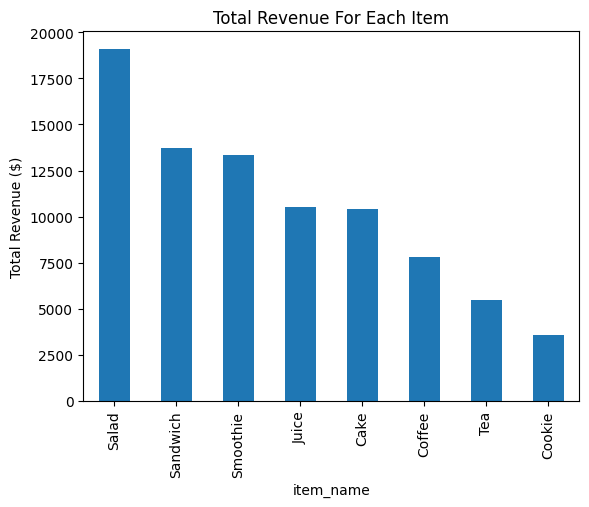

In [42]:
(df
.groupBy('item_name')
.agg(F.sum('item_total_price').alias('total_revenue') )
.orderBy('total_revenue',ascending =False)
.dropna() # excluding Null
.toPandas()
.plot.bar(x='item_name',
          ylabel='Total Revenue ($)',
          title='Total Revenue For Each Item',
          legend=False)  
);

2. Create a pie chart showing the distribution of payment methods.


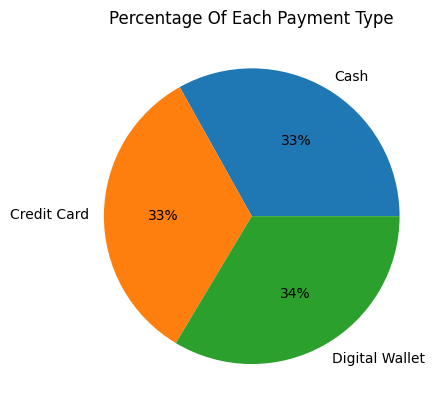

In [43]:
df_pie=(df
.groupBy('payment_type')
.count()
.orderBy('payment_type')
.dropna() # excluding Null
.toPandas())

# Pie chart labels must reference a pandas column, so df is converted to pandas (df_pie) for labeling.
df_pie.plot.pie(labels=df_pie['payment_type'],
                y='count',
                ylabel='',
                title='Percentage Of Each Payment Type',
                legend=False,
                autopct='%1.0f%%');

3. Create a line chart showing total monthly sales.


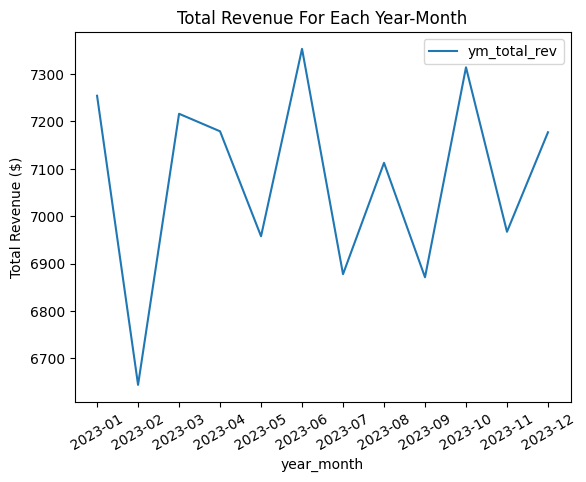

In [44]:
df_line = (df
.withColumn('year_month', F.date_format('transaction_date','yyyy-MM'))
.groupBy('year_month')
.agg(F.sum('item_total_price').alias('ym_total_rev'))
.orderBy('year_month')
.dropna() # excluding Null
.toPandas())

# For advanced label setting, we have to create an axis object and use set_xticks / set_xticklabels
ax = df_line.plot.line(x='year_month', 
                    ylabel='Total Revenue ($)',
                    title='Total Revenue For Each Year-Month',
                    )    

ax.set_xticks(range(len(df_line)))
ax.set_xticklabels(df_line['year_month'], rotation=30);

4. Create a stacked bar chart showing sales per location broken down by item.

ref : https://www.geeksforgeeks.org/python/create-a-stacked-bar-plot-in-matplotlib/. 

We will use dataframe plot as in Example 3 in the ref, so we have to acquire a pivoted dataframe like
| Team | Round 1 | Round 2 | Round 3 | Round 4 |
|------|---------|---------|---------|---------|
| A    | 10      | 20      | 10      | 26      |
| B    | 20      | 25      | 15      | 21      |
| C    | 12      | 15      | 19      | 6       |
| D    | 10      | 18      | 11      | 8       |


In [45]:
# try to create pivoted df
(df
.filter(~F.col('location_type').isNull()) # select only 'In-store' and 'Takeaway' and exclude Null from item_name
.groupBy('item_name')
.pivot("location_type")
.sum("item_quantity")  
.show())

+---------+--------+--------+
|item_name|In-store|Takeaway|
+---------+--------+--------+
|    Salad|  1227.0|  1113.0|
|      Tea|  1136.0|  1105.0|
|     NULL|   428.0|   476.0|
| Sandwich|  1127.0|  1054.0|
|    Juice|  1103.0|   992.0|
| Smoothie|   953.0|   922.0|
|   Coffee|  1078.0|  1215.0|
|     Cake|   991.0|  1048.0|
|   Cookie|  1090.0|  1219.0|
+---------+--------+--------+



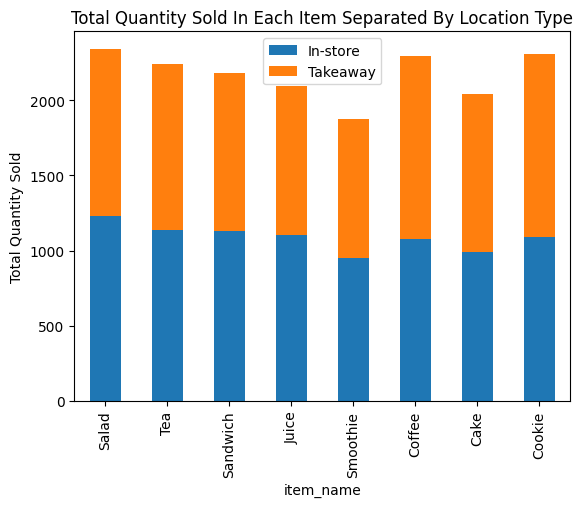

In [46]:
(df
.filter(~F.col('location_type').isNull())
.groupBy('item_name')
.pivot("location_type")
.sum("item_quantity")  
.dropna() # excluding Null
.toPandas()
.plot.bar(x='item_name',
          stacked=True,
          ylabel='Total Quantity Sold',
          title='Total Quantity Sold In Each Item Separated By Location Type',
          legend=True)  
);

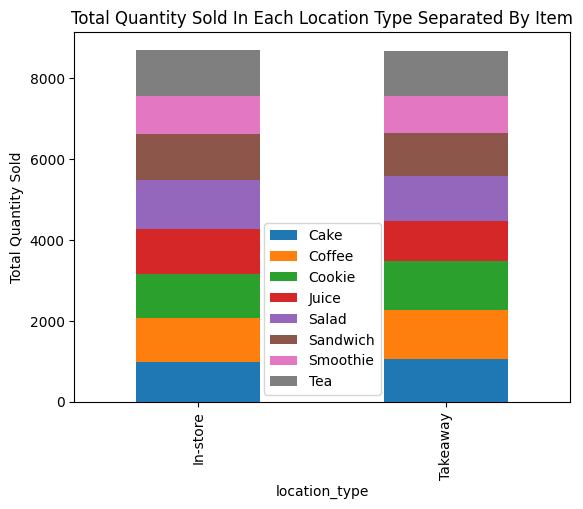

In [47]:
(df
.filter(~F.col('item_name').isNull())
.groupBy('location_type')
.pivot("item_name")
.sum("item_quantity")  
.dropna() # excluding Null
.toPandas()
.plot.bar(x='location_type',
          stacked=True,
          ylabel='Total Quantity Sold',
          title='Total Quantity Sold In Each Location Type Separated By Item',
          legend=True)  
);

5. Create a box plot of Total Item Price grouped by item.

In [54]:
# try to create pivoted df
(df
.select('item_name','item_total_price')
# .agg(F.sum("item_quantity").alias('total_qty_sold'))
.dropna()
.show())

+---------+----------------+
|item_name|item_total_price|
+---------+----------------+
|   Coffee|             4.0|
|     Cake|            12.0|
|   Cookie|             4.0|
|    Salad|            10.0|
|   Coffee|             4.0|
| Smoothie|            20.0|
| Sandwich|            16.0|
| Sandwich|            20.0|
|    Salad|            25.0|
| Sandwich|             8.0|
| Sandwich|             8.0|
|   Cookie|             5.0|
|      Tea|             3.0|
|    Salad|            15.0|
| Sandwich|             4.0|
|    Juice|             6.0|
|     Cake|            15.0|
|    Juice|            12.0|
| Smoothie|            20.0|
| Smoothie|            16.0|
+---------+----------------+
only showing top 20 rows


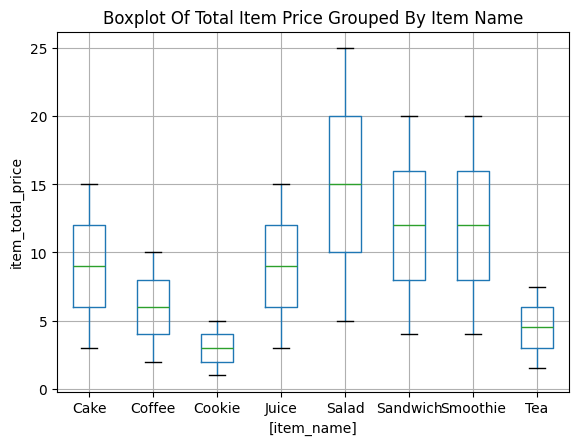

In [98]:
ax = (df
.select('item_name','item_total_price')
.dropna()
.toPandas()
.boxplot(by='item_name')) 
# .boxplot creates a Figure (parent object) with an auto generated figure's title and then plot in an Axes (subplot)

# use matplotlib.pyplot.gcf to get the current figure 
import matplotlib.pyplot as plt
fig = plt.gcf()  
# use .suptitle to access its parent's title and set to new value (remove)		
fig.suptitle('');

# set the Axes' title (subplot) (won't replace its parent's title)
ax.set_title('Boxplot Of Total Item Price Grouped By Item Name');
ax.set_ylabel('item_total_price');